# Burgers Optimization with a DL-based DP

As shown in the previous example, the differentable Burgers solver allows us to easily backpopragate through arbitrary sequences of time-updates. (If you haven't done so, please check out the "manual" example of the previous notebook - the setup below directly builds on that one.)

Now, let's use a "proper" DL framework for this task, i.e. an actual optimizer from TensorFlow. This is more flexible as will also be applicable to NN training runs later on, and will make the optimization much faster. The first step, setting up the simulation is almost identical to before:

In [1]:
from phi.tf.flow import *

# run with phiflow
n = 128
steps = 32
dt = 1./steps
initial = np.zeros([n,1]) # start from 0

domain = Domain([n], boundaries=PERIODIC, box=box[-1:1])
state0 = BurgersVelocity(domain, velocity=initial, viscosity=0.01/np.pi)

# now use a real TF variable instead
state_in = state0.copied_with(velocity= variable(state0.velocity) ) # <-- main change!
states = [state_in]

for i in range(steps):
    states.append( Burgers().step(states[-1],dt=dt) )

Could not load resample cuda libraries: CUDA binaries not found at /Users/thuerey/Dropbox/mbaDevelSelected/phiflow-v1.5/phi/tf/cuda/build/resample.so. Run "python setup.py cuda" to compile them



Instructions for updating:
Use `tf.cast` instead.





/Users/thuerey/Dropbox/mbaDevelSelected/phiflow-v1.5/phi/tf/flow.py:15: UserWarning: TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run
$ python setup.py tf_cuda
before reinstalling phiflow.
  warnings.warn("TensorFlow-CUDA solver is not available. To compile it, download phiflow sources and run\n$ python setup.py tf_cuda\nbefore reinstalling phiflow.")


It's easy to overlook, but there was an important change here: we've declared the initial state of the simulation to be a `tf.variable`. 

Now we don't need to keep track and pass along `state_in` as in the previous manual example, TF knows about the initial state as a variable we'd like to optimize. This is in contrast to the previous version of this optimization, where we explicitly stored and updated the `state_in` field containing the intial state.

Nonetheless, this likewise didnt run anything! We only have a graph of operations in tensorflow so far. Let's set up the loss like before:

In [3]:
sess = Session(None) 

solution_t16 = np.asarray( [0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] )
target = state0.copied_with(velocity=np.reshape(solution_t16,[n,1]))

loss = math.sum( (states[16].velocity.data - target.velocity.data)**2 ) / n

As the graph encodes the full temporal sequence, and we can compute and propagate derivatives for all intermediates, we can can now backpropagate a gradient for this loss to any earlier variable, and hence also the initial velocity state that we're interested in (and that we already declared as a `variable()` to TF above).

Also, in contrast to the PINN example we don't need additional terms for enforcing the boundary conditions, these are already present in the simulation, and hence encoded in the execution graph for the `states` sequence above.

Now we're ready to run the optimization with one of the optimizers provided in tensorflow, e.g., the simplest starting point is always _gradient descent_ (GD), i.e. the `tf.train.GradientDescentOptimizer` from TF:

In [4]:
LR = 5.

optim = tf.train.GradientDescentOptimizer(learning_rate=LR).minimize(loss)
#optim = tf.train.AdamOptimizer(learning_rate=0.05).minimize(loss) # overshoots?
sess.initialize_variables() 

print('Initial loss: %f' % sess.run(loss))

import time
start = time.time()

for optim_step in range(50):
    _, loss_value = sess.run([optim, loss])
    
    if optim_step%5==0: 
        print('Optimization step %d, loss: %f' % (optim_step,loss_value))

end = time.time()
print("Runtime {:.2f}s".format(end-start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Initial loss: 0.382915
Step 0, loss: 0.382915
Step 5, loss: 0.194040
Step 10, loss: 0.103610
Step 15, loss: 0.059475
Step 20, loss: 0.035991
Step 25, loss: 0.022581
Step 30, loss: 0.014490
Step 35, loss: 0.009447
Step 40, loss: 0.006238
Step 45, loss: 0.004161
Runtime 1.32s


This code already includes a timer, and already ran 50 steps which should take around one second. This is much faster than our previous "manual" version. Also, the loss now then down to below 0.005.

Let's visualize the reconstruction: first let's check how well the last state of the simulation matches the target:

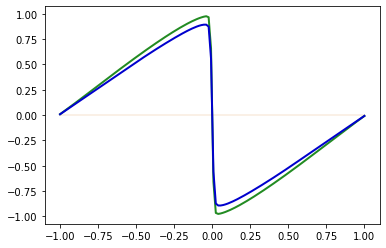

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure().gca()
pltx = np.linspace(-1,1,n)

# initial guess for optimization, this is where we started out...
fig.plot(pltx, initial.flatten()             , lw=2, color='linen')  

# target constraint at t=0.5
fig.plot(pltx, target.velocity.data.flatten(), lw=2, color='forestgreen') 

# constrained state of simulation
contrained_state = sess.run(states[16]).velocity.data
fig.plot(pltx, contrained_state.flatten(), lw=2, color='mediumblue')

Not bad. How well is the initial state recovered via backpropagation through the 16 simulation steps?

This also matches quite well, as shown in the next plot. Naturally, this is a tougher task: the optimization receives direct feedback what the state at $t=0.5$ should look like, but due to the non-linear model equation, we typically have a large number of solution that exactly or numerically very closely satisfy the constraints. Hence, our minimizer not necessarily finds the exact state we started from. It's still quite close in this Burgers scenario:

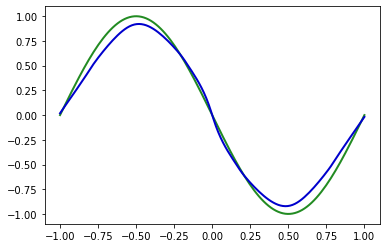

In [7]:
fig = plt.figure().gca()
pltx = np.linspace(-1,1,n)

# ground truth state at time=0 , move down
t0gt = np.asarray( [ [-math.sin(np.pi * x) * 1.] for x in np.linspace(-1,1,n)] )
fig.plot(pltx, t0gt.flatten()             , lw=2, color='forestgreen')  # ground truth initial state of sim

#fig.plot(pltx, stateN.velocity.data.flatten(), lw=2, color='mediumblue') # manual
fig.plot(pltx, sess.run(states[0]).velocity.data.flatten(), lw=2, color='mediumblue') # manual


This was all very qualitative so far. Before measuring the overall error of the reconstruction, let's visualize the full evolution of our system over time as this also yields the solution in the form of a numpy array that we can compare to the other versions:

Vels array shape: (1, 128, 33, 1)


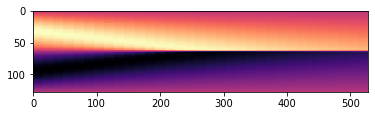

In [8]:
def show_state(a):
    # we only have 33 time steps, blow up by a factor of 2^4 to make it easier to see
    for i in range(4):
        a = np.concatenate( [a,a] , axis=3)

    a = np.reshape( a, [a.shape[1],a.shape[2]*a.shape[3]] )
    plt.imshow(a, origin='upper', cmap='magma')
    
# run all states through TF to get numpy arrays 
vels = sess.run(states) # convert all states in 1 sess.run() call
vels = [ x.velocity.data for x in vels] 
#vels = np.asarray( [ sess.run(x, feed_dict={state_in: stateN}).velocity.data for x in states] ) # also works, but slower
vels = np.concatenate(vels, axis=-1)
vels = np.reshape(vels, list(vels.shape)+[1] ) ; print("Vels array shape: "+format(vels.shape))

# save for comparison with other methods
np.savez_compressed("./temp/burgers-diffphys-solution.npz", np.reshape(vels,[n,steps+1])) # remove batch & channel dimension

show_state(vels)

## Physics-Informed vs. Differentiable Physics Reconstruction

Now we have both versions, so let's compare both reconstructions in more detail.

Let's first look at the solutions side by side. The code below generates an image with 3 versions, from top to bottom: the "ground truth" (GT) solution as given by the regular forward simulation, in the middle the PINN reconstruction, and at the bottom the differentiable physics version.




Solutions Ground Truth (top), PINN (middle) , DiffPhys (bottom):


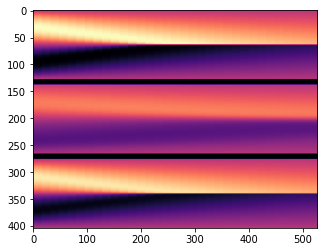

In [10]:
# note, this requires running the forward sim & PINN notebooks beforehand
sol_gt=npfile=np.load("./temp/burgers-groundtruth-solution.npz")["arr_0"] ; #print(format(sol_gt.shape)) 
sol_pi=npfile=np.load("./temp/burgers-pinn-solution.npz")["arr_0"] ; #print(format(sol_pi.shape)) 
sol_dp=npfile=np.load("./temp/burgers-diffphys-solution.npz")["arr_0"] ; #print(format(sol_dp.shape)) 

divider = np.ones([10,33])*-1. # we'll sneak in a block of -1s to show a black divider in the image
sbs = np.concatenate( [sol_gt, divider, sol_pi, divider, sol_dp], axis=0)

print("\nSolutions Ground Truth (top), PINN (middle) , DiffPhys (bottom):")
show_state(np.reshape(sbs,[1,n*3+20,33,1]))

It's clealry visible here that the PINN solution recovers the overall shape of the solution, hence the temporal constraints are at least partially fulfilled. However, it doesn't manage to capture the amplitudes of the GT solution very well.

The reconstruction from the optimization with a differentiable solver is much closer to the ground truth thanks to an improved flow of gradients over the whole course of the sequence. In addition, it can leverage the grid-based discretization for both forwards as well as backwards passes, and in this way provide a more accurate signal to the unknown initial state. It is nonetheless visible, that the reconstruction lacks certain "sharper" features of the GT version, e.g., visible in the bottom left corner of the solution image.

Let's quantify these errors over the whole sequence:

MAE PINN: 	0.23629 
MAE DiffPhys: 	0.04718

Error GT to PINN (top) , DiffPhys (bottom):


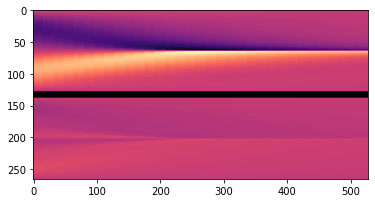

In [11]:
err_pi = np.sum( np.abs(sol_pi-sol_gt)) / (steps*n)
err_dp = np.sum( np.abs(sol_dp-sol_gt)) / (steps*n)
print("MAE PINN: \t{:7.5f} \nMAE DiffPhys: \t{:7.5f}".format(err_pi,err_dp))

print("\nError GT to PINN (top) , DiffPhys (bottom):")
show_state(np.reshape( np.concatenate([sol_pi-sol_gt, divider, sol_dp-sol_gt],axis=0) ,[1,n*2+10,33,1]))

That's a pretty clear result: the PINN error is ca. 5 times higher than the Differentiable Physics (DP) reconstruction.

This difference also shows clearly in the jointly visualized image at the bottom: the magnitudes of the errors of the DP reconstruction are much closer to zero, as indicated by the purple color above.

Now we have a first example to show similarities and differences of the two approaches. In the section, we'll present a more in depth discussion of these findings, before moving to more complex cases.


---

## Next steps

As with the PINN version, there's variety of things that can be improved and experimented with here:

* You can try to adjust the training parameters to improve the reconstruction.
* As for the PINN case, you can activate a different optimizer, and observe the changing (not necessarily improved) behavior.
* Vary the number of steps, or the resolution of the simulation and reconstruction.